In [ ]:
!pip install opendatasets
!pip install tld
!pip install scikit-learn==1.4.1.post1
!pip install nltk==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import opendatasets as od
import numpy as np
import string
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tld import get_tld, is_tld
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier
import spacy
from sklearn.svm import SVC
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from xgboost import XGBClassifier
nlp = spacy.load("en_core_web_sm")

od.download("https://www.kaggle.com/datasets/venky73/spam-mails-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aswinr24
Your Kaggle Key: ··········


100%|██████████| 1.86M/1.86M [00:00<00:00, 89.8MB/s]

In [ ]:
nltk.download('stopwords')   #stopwords data
nltk.download('punkt')       #tokenizer data
data = pd.read_csv('spam-mails-dataset/spam_ham_dataset.csv',header=0)
data = pd.DataFrame(data)
data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


Removing unnamed: 0 column

In [ ]:
data=data.drop(['Unnamed: 0'],axis=1)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [ ]:
data.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [ ]:
count = data.label.value_counts()
count

ham     3672
spam    1499
Name: label, dtype: int64

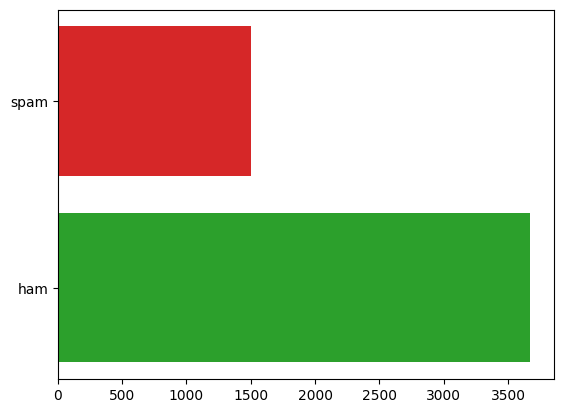

In [ ]:
bar_colors = ['tab:green', 'tab:red']
plt.barh(count.index,count,color=bar_colors)
plt.show()

**Extracting Subject from the e-mails**

In [ ]:
def subject(text):
  sub=''
  for i in text:
    if(i == '\r'):
      break
    sub+=i
  return sub

data['subject']=data['text'].apply(lambda i: subject(i))
data

,label,text,label_num,subject
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,Subject: enron methanol ; meter # : 988291
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"Subject: hpl nom for january 9 , 2001"
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,Subject: neon retreat
3,spam,"Subject: photoshop , windows , office . cheap ...",1,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,Subject: re : indian springs
...,...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0,Subject: put the 10 on the ft
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,Subject: 3 / 4 / 2000 and following noms
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0,Subject: calpine daily gas nomination
5169,ham,Subject: industrial worksheets for august 2000...,0,Subject: industrial worksheets for august 2000...


In [ ]:
data['subject']=data['subject'].apply(lambda i: i.replace('Subject',''))
data

,label,text,label_num,subject
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,: enron methanol ; meter # : 988291
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,": hpl nom for january 9 , 2001"
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,: neon retreat
3,spam,"Subject: photoshop , windows , office . cheap ...",1,": photoshop , windows , office . cheap . main ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,: re : indian springs
...,...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0,: put the 10 on the ft
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,: 3 / 4 / 2000 and following noms
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0,: calpine daily gas nomination
5169,ham,Subject: industrial worksheets for august 2000...,0,: industrial worksheets for august 2000 activity


Removing special characters and punctuation marks

In [ ]:
stemmer = PorterStemmer()
def transform(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    current = []
    for i in text:
        if i.isalnum():
            current.append(i)
    text = current[:]
    current.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            current.append(i)
    text = current[:]
    current.clear()
    for i in text:
        current.append(stemmer.stem(i))
    return " ".join(current)
data['text']=data['text'].apply(lambda i: transform(i))
data['subject']=data['subject'].apply(lambda i: transform(i))
data

,label,text,label_num,subject
0,ham,subject enron methanol meter 988291 follow not...,0,subject enron methanol meter 988291
1,ham,subject hpl nom januari 9 2001 see attach file...,0,subject hpl nom januari 9 2001
2,ham,subject neon retreat ho ho ho around wonder ti...,0,subject neon retreat
3,spam,subject photoshop window offic cheap main tren...,1,subject photoshop window offic cheap main trend
4,ham,subject indian spring deal book teco pvr reven...,0,subject indian spring
...,...,...,...,...
5166,ham,subject put 10 ft transport volum decreas 2500...,0,subject put 10 ft
5167,ham,subject 3 4 2000 follow nom hpl take extra 15 ...,0,subject 3 4 2000 follow nom
5168,ham,subject calpin daili ga nomin juli mention ear...,0,subject calpin daili ga nomin
5169,ham,subject industri worksheet august 2000 activ a...,0,subject industri worksheet august 2000 activ


In [ ]:
more_stopwords = {'re' , 's' , 'subject','hpl','hou','enron'}
STOPWORDS = STOPWORDS.union(more_stopwords)

**Word frequency and word cloud**

In [ ]:
word_dict={}
def count(text):
    words = text.split()
    for w in words:
        if not w in word_dict:
             word_dict[w]=1
        else:
             word_dict[w]+=1
data['text'].apply(lambda i: count(i))
word_dict=sorted(word_dict.items(), key=lambda x:x[1],reverse=True)
data2=pd.DataFrame(word_dict)
data2.head(20)

,0,1
0,ect,13908
1,subject,8064
2,hou,7289
3,enron,6555
4,2000,4386
5,com,3709
6,deal,3655
7,pleas,3243
8,ga,3072
9,3,2922


Spam mails word cloud

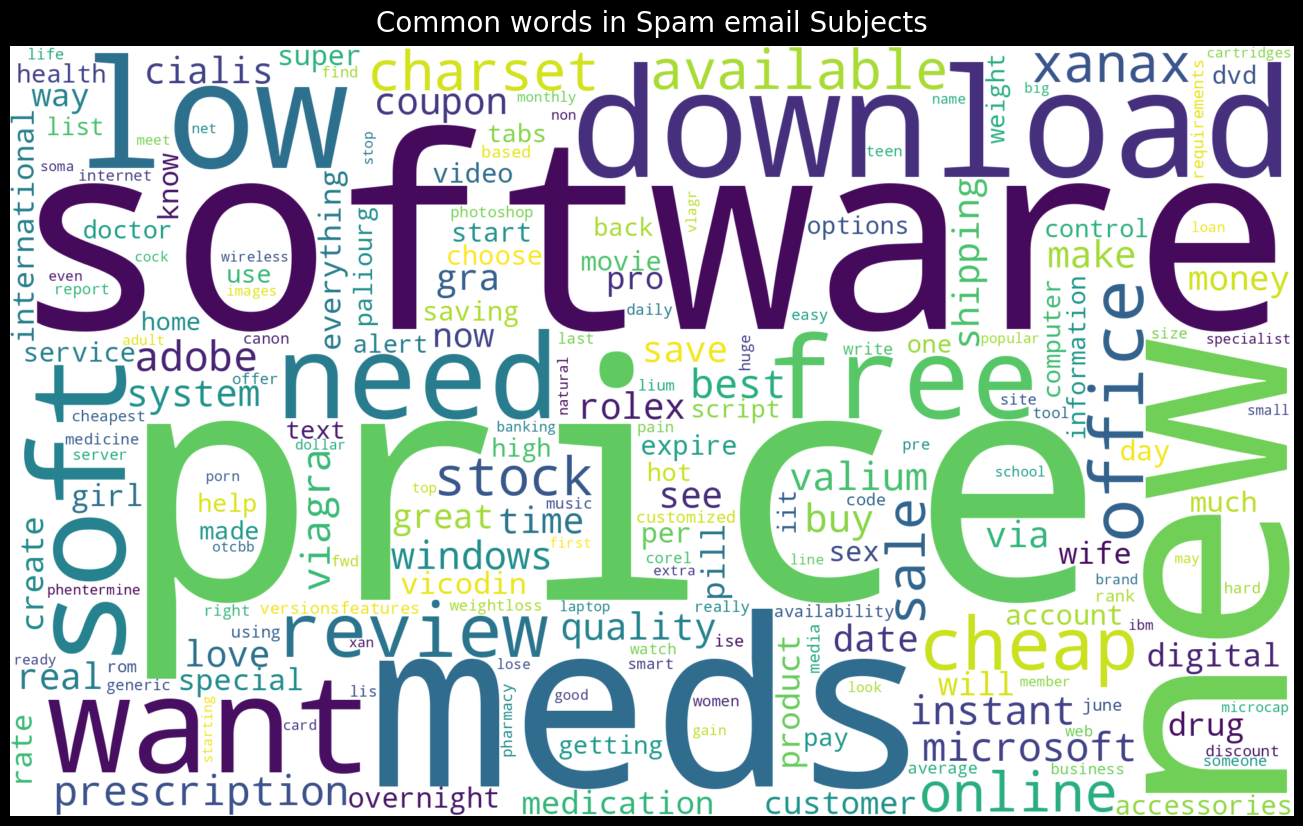

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white',stopwords=STOPWORDS
                       ,width=2000, height=1200).generate("".join(data[data['label_num']==1]["subject"]))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Common words in Spam email Subjects",fontdict={'size': 20, 'color': 'white','verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

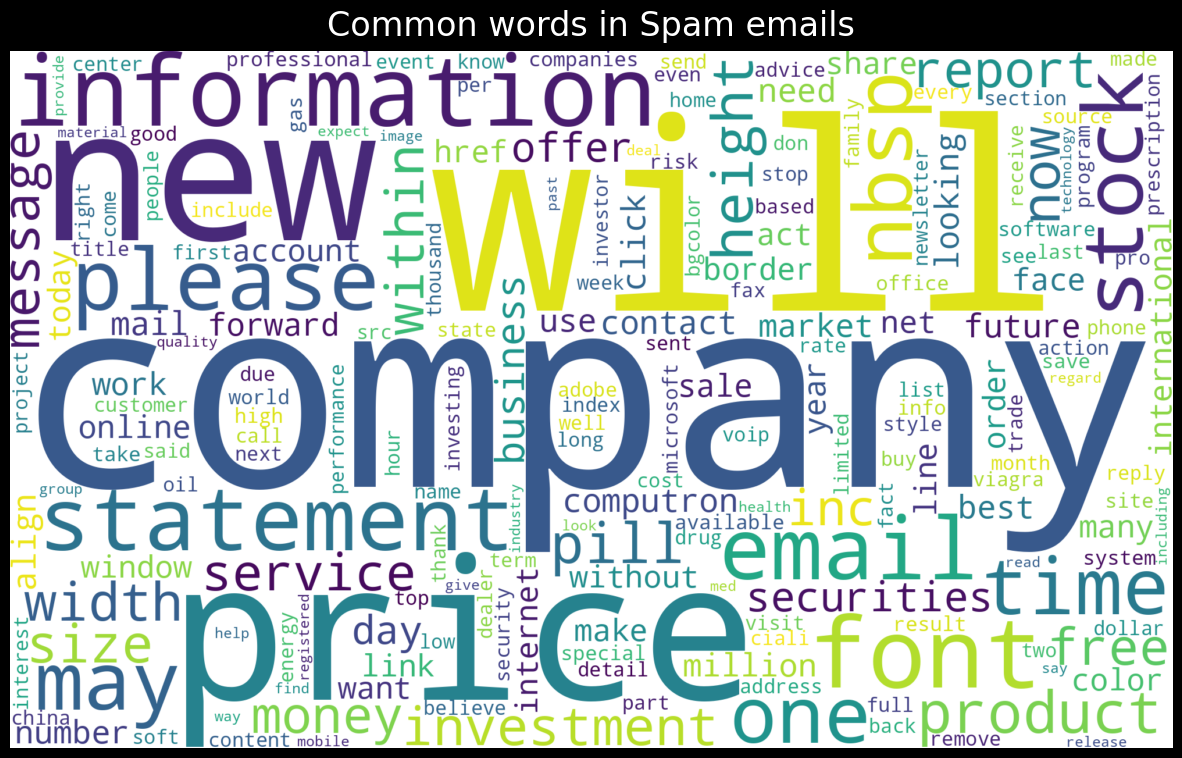

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white',stopwords=STOPWORDS
                       ,width=2000, height=1200).generate("".join(data[data['label_num']==1]["text"]))
plt.figure( figsize=(15,15), facecolor='k')
plt.title("Common words in Spam emails",fontdict={'size': 24, 'color': 'white','verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Ham(safe) e-mails word cloud

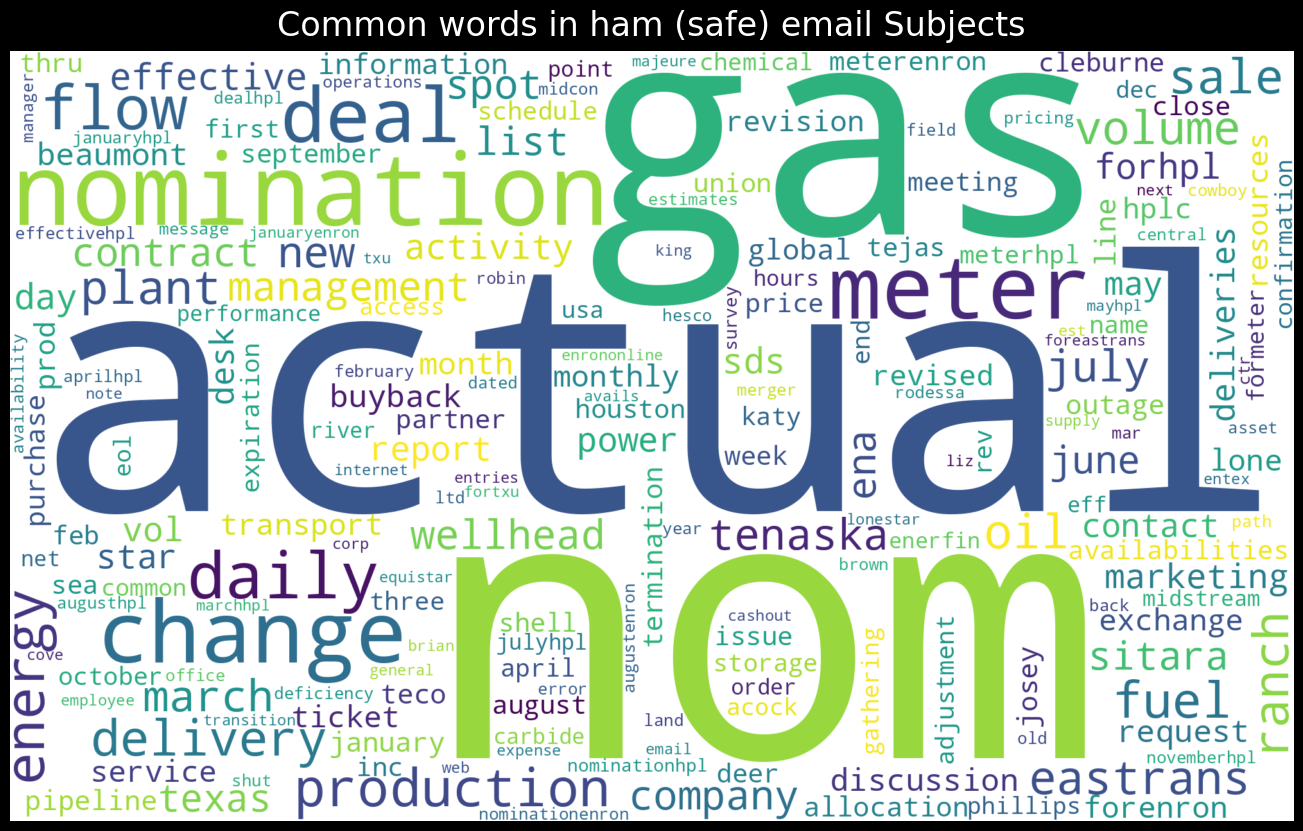

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white',stopwords=STOPWORDS
                       ,width=2000, height=1200).generate("".join(data[data['label_num']==0]["subject"]))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Common words in ham (safe) email Subjects",fontdict={'size': 24, 'color': 'white','verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

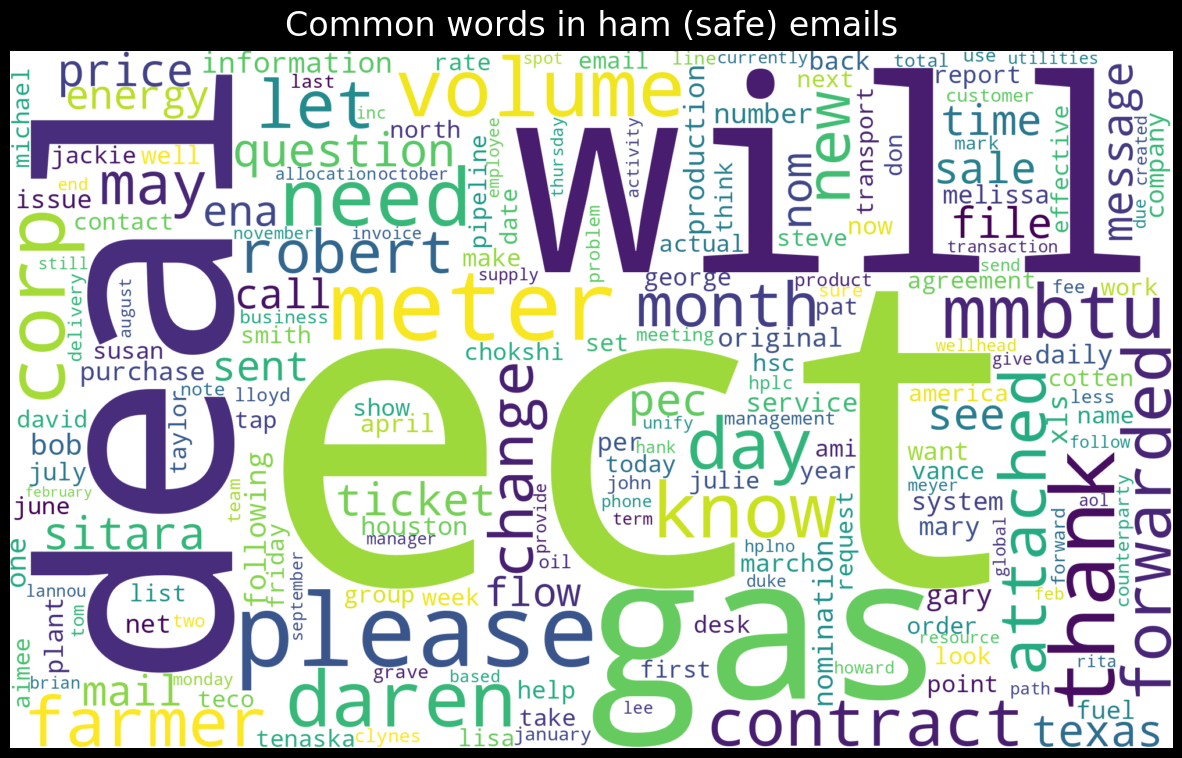

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white',stopwords=STOPWORDS
                       ,width=2000, height=1200).generate("".join(data[data['label_num']==0]["text"]))
plt.figure( figsize=(15,15), facecolor='k')
plt.title("Common words in ham (safe) emails",fontdict={'size': 24, 'color': 'white','verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Training the model**

In [ ]:
X = data['text'].tolist()
y = data['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfid = vectorizer.fit_transform(X_train)
X_test_tfid = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_tfid)

print(X_train_tfid)

  (0, 1853)	0.11356391562035449
  (0, 31295)	0.10166340732944035
  (0, 33851)	0.033492990382545273
  (0, 34109)	0.04694500179066047
  (0, 5133)	0.11036793429392197
  (0, 10708)	0.0638589826208588
  (0, 35111)	0.09193376536674276
  (0, 2788)	0.11188589163279511
  (0, 11309)	0.10252450879297959
  (0, 22277)	0.06929606989530117
  (0, 10972)	0.05577023127034392
  (0, 21380)	0.040344041236969705
  (0, 22074)	0.04370735690930972
  (0, 36951)	0.13371337669214214
  (0, 32094)	0.07055257407156362
  (0, 19685)	0.047494245787097954
  (0, 35443)	0.04862302577821986
  (0, 22199)	0.05198314745259295
  (0, 37136)	0.04817936206241063
  (0, 14944)	0.06974159537947819
  (0, 24984)	0.03940895655737957
  (0, 14206)	0.09062400050206544
  (0, 25127)	0.11902633448837743
  (0, 7042)	0.12866887152671677
  (0, 22288)	0.055170900157047446
  :	:
  (4135, 0)	0.25107273363006266
  (4135, 20849)	0.20845415719057758
  (4135, 9154)	0.08007117351915903
  (4135, 21743)	0.17523570325901575
  (4135, 4879)	0.32774880919594


Model Name:
<class 'sklearn.tree._classes.DecisionTreeClassifier'> 


Test Accuracy 

0.9458937198067633 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       742
           1       0.91      0.90      0.90       293

    accuracy                           0.95      1035
   macro avg       0.93      0.93      0.93      1035
weighted avg       0.95      0.95      0.95      1035


Confusion_matrix 



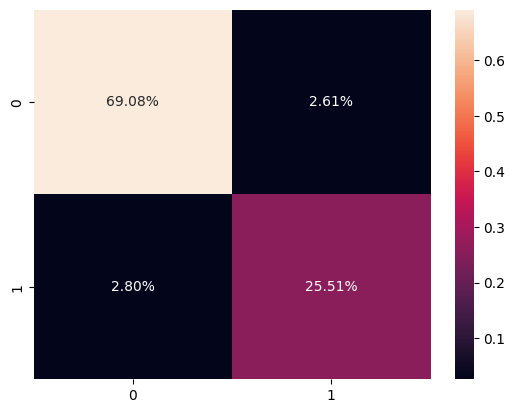


Model Name:
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 


Test Accuracy 

0.9816425120772947 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.97      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035


Confusion_matrix 



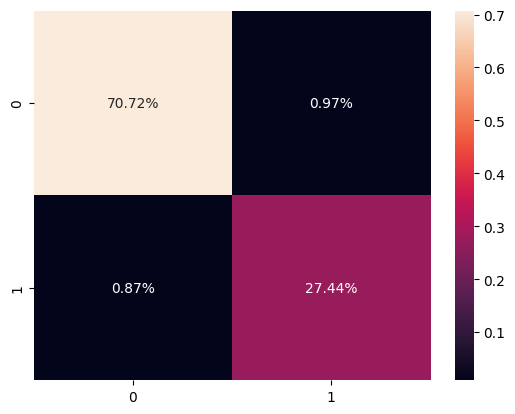


Model Name:
<class 'sklearn.linear_model._logistic.LogisticRegression'> 


Test Accuracy 

0.9835748792270531 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       742
           1       0.96      0.99      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035


Confusion_matrix 



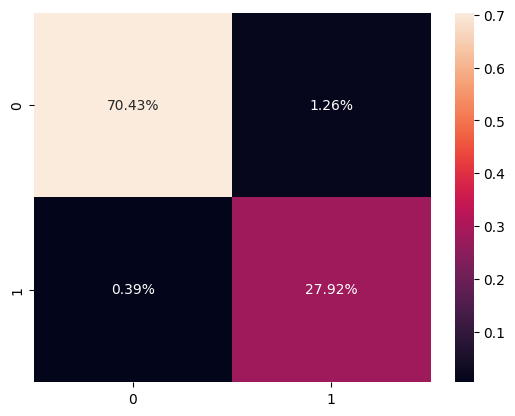


Model Name:
<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 


Test Accuracy 

0.991304347826087 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       742
           1       0.98      0.99      0.98       293

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035


Confusion_matrix 



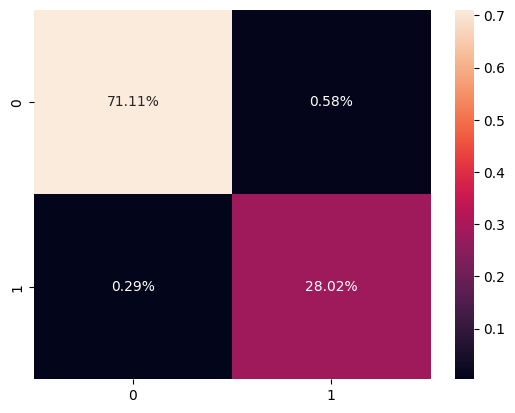


Model Name:
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 


Test Accuracy 

0.9826086956521739 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.97      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035


Confusion_matrix 



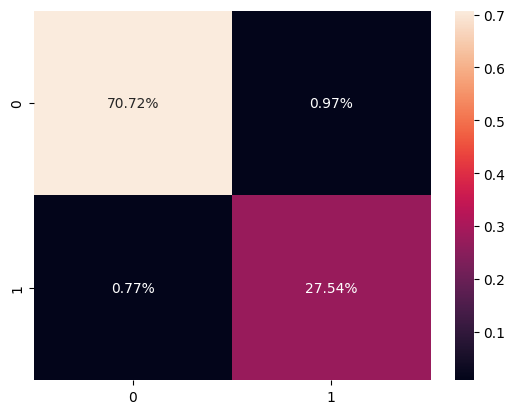


Model Name:
<class 'sklearn.naive_bayes.MultinomialNB'> 


Test Accuracy 

0.9207729468599034 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       742
           1       1.00      0.72      0.84       293

    accuracy                           0.92      1035
   macro avg       0.95      0.86      0.89      1035
weighted avg       0.93      0.92      0.92      1035


Confusion_matrix 



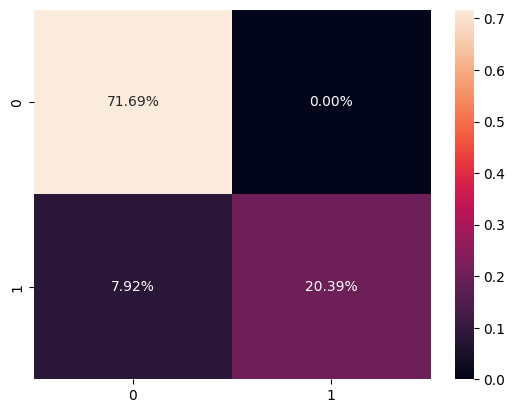


Model Name:
<class 'sklearn.svm._classes.SVC'> 


Test Accuracy 

0.9864734299516909 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.99      0.98       293

    accuracy                           0.99      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.99      0.99      0.99      1035


Confusion_matrix 



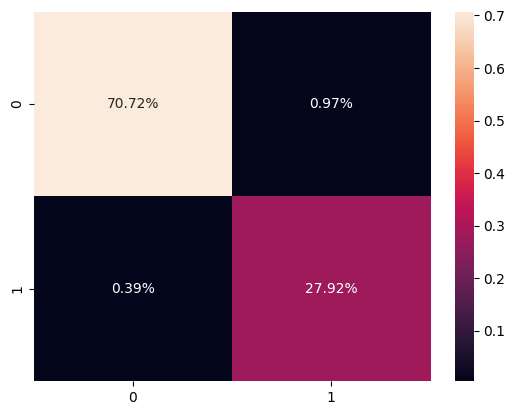


Model Name:
<class 'xgboost.sklearn.XGBClassifier'> 


Test Accuracy 

0.9739130434782609 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       742
           1       0.93      0.98      0.95       293

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035


Confusion_matrix 



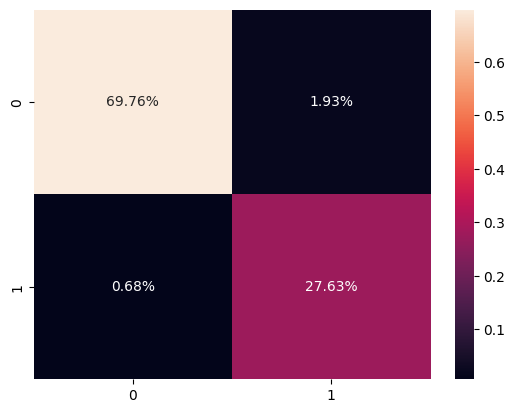

In [ ]:
models = [DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,SGDClassifier,
         ExtraTreesClassifier, MultinomialNB, SVC, XGBClassifier]
accuracy_test=[]
for m in models:
    print(f'\nModel Name:')
    print(str(m),'\n')
    model_ = m()
    model_.fit(X_train_tfid, y_train)
    pred = model_.predict(X_test_tfid)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('\nTest Accuracy \n')
    print(acc,'\n')
    print(classification_report(y_test, pred))
    print('\nConfusion_matrix \n')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()

In [ ]:
classifier = SVC(kernel = "sigmoid", gamma  = 1.0)
classifier.fit(X_train_tfid, y_train)
pred = classifier.predict(X_test_tfid)
acc = accuracy_score(pred, y_test)
print(confusion_matrix(y_test,pred))
print('Accuracy : ',(acc*100))
print(classification_report(y_test, pred))

[[734   8]
 [  3 290]]
Accuracy :  98.93719806763285
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       742
           1       0.97      0.99      0.98       293

    accuracy                           0.99      1035
   macro avg       0.98      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035



Saving trained model

In [ ]:
joblib.dump(classifier, 'SVC_spamMail_classifier.pkl',compress=3)

['SVC_spamMail_classifier.pkl']

In [ ]:
joblib.dump(vectorizer, 'vectorizer_mail.pkl',compress=3)

['vectorizer_mail.pkl']

In [ ]:
mail=input()
print(mail)
mail = [transform(mail)]
vectorizer2=joblib.load('vectorizer_mail.pkl')
mail = vectorizer2.transform(mail)
print("\n")

predict_mail = classifier.predict(mail)

if predict_mail == 0:
    print("\nSafe e-mail")
else:
    print("\nALERT! spam e-mail")

vectorizer_mail.pkl
vectorizer_mail.pkl



ALERT! spam e-mail
